In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load a chunk of the dataset
chunk_size = 50000  # Set a chunk size to manage memory
data_iter = pd.read_csv('data.csv', chunksize=chunk_size)

# Initialize list to collect filtered data chunks
filtered_chunks = []

# Process each chunk to filter out non-standard amino acids
for chunk in data_iter:
    # Escape the '*' character to treat it as a literal
    chunk_filtered = chunk[~chunk['seq'].str.contains(r'\*', regex=True)]
    filtered_chunks.append(chunk_filtered)

# Concatenate the filtered chunks into a single DataFrame
filtered_data = pd.concat(filtered_chunks, ignore_index=True)

# Display the number of rows after filtering
print(f'Number of rows after filtering: {filtered_data.shape[0]}')


Number of rows after filtering: 386333


In [3]:
# Define the sample size suitable for 4 GB RAM
sample_size = 10000  # Adjust based on available memory and processing power

# Randomly sample from the filtered data
if filtered_data.shape[0] > sample_size:
    sampled_data = filtered_data.sample(n=sample_size, random_state=42)
else:
    sampled_data = filtered_data

print(f'Number of rows after sampling: {sampled_data.shape[0]}')


Number of rows after sampling: 10000


In [4]:
# Function to one-hot encode amino acid sequences
def one_hot_encode(seq, window_size=15):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    encoding = np.zeros((window_size, len(amino_acids)), dtype=np.float32)
    for i in range(min(len(seq), window_size)):
        aa = seq[i]
        if aa in amino_acids:
            encoding[i, amino_acids.index(aa)] = 1
    return encoding

# Initialize lists for features and labels
X = []
y = []

# Use Q3 state (sst3) for labels
for _, row in sampled_data.iterrows():
    sequence = row['seq']
    sst3 = row['sst3']
    if len(sequence) < 15:
        continue
    for i in range(len(sequence) - 15 + 1):
        X.append(one_hot_encode(sequence[i:i + 15], 15))
        y.append(sst3[i + 7])  # Take the label from the middle of the window

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

# Map Q3 labels to integers: H -> 0, E -> 1, C -> 2
label_map = {'H': 0, 'E': 1, 'C': 2, 'B': 3, 'G': 4, 'I': 5, 'T': 6, 'S': 7}
y_numeric = np.array([label_map[c] for c in y])

# Display shapes of the feature and label arrays
print(f'Feature shape: {X.shape}')
print(f'Label shape: {y_numeric.shape}')

Feature shape: (2477682, 15, 20)
Label shape: (2477682,)


In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(f'Training feature shape: {X_train.shape}')
print(f'Training label shape: {y_train.shape}')
print(f'Testing feature shape: {X_test.shape}')
print(f'Testing label shape: {y_test.shape}')

Training feature shape: (1982145, 15, 20)
Training label shape: (1982145,)
Testing feature shape: (495537, 15, 20)
Testing label shape: (495537,)


C:\Users\aksha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
55748/55748 ━━━━━━━━━━━━━━━━━━━━ 291s 5ms/step - accuracy: 0.6477 - loss: 0.8021 - val_accuracy: 0.6775 - val_loss: 0.7403
Epoch 2/5
55748/55748 ━━━━━━━━━━━━━━━━━━━━ 341s 5ms/step - accuracy: 0.6745 - loss: 0.7544 - val_accuracy: 0.6816 - val_loss: 0.7319
Epoch 3/5
55748/55748 ━━━━━━━━━━━━━━━━━━━━ 289s 5ms/step - accuracy: 0.6794 - loss: 0.7460 - val_accuracy: 0.6868 - val_loss: 0.7258
Epoch 4/5
55748/55748 ━━━━━━━━━━━━━━━━━━━━ 277s 5ms/step - accuracy: 0.6826 - loss: 0.7402 - val_accuracy: 0.6895 - val_loss: 0.7190
Epoch 5/5
55748/55748 ━━━━━━━━━━━━━━━━━━━━ 290s 5ms/step - accuracy: 0.6832 - loss: 0.7384 - val_accuracy: 0.6909 - val_loss: 0.7150


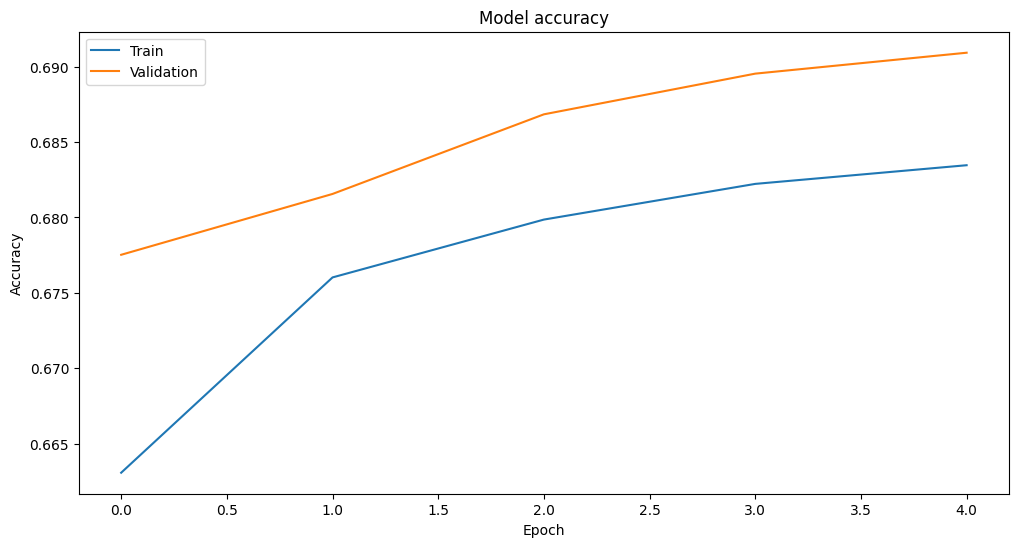

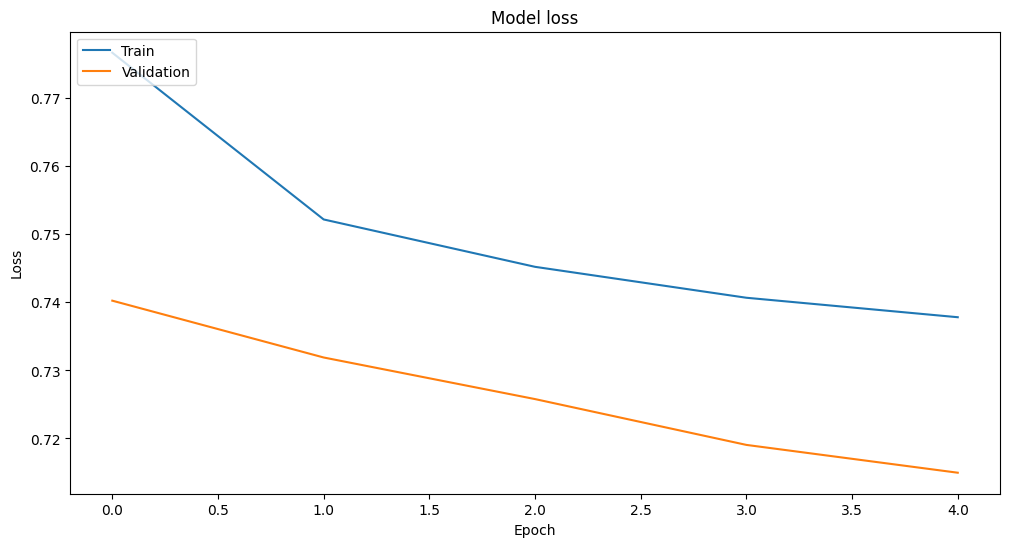

In [6]:
# Define the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(15, 20)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer for Q3 (3 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with a smaller batch size
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [7]:
# Predict on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


15486/15486 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
Accuracy: 0.69
F1 Score: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72    175285
           1       0.66      0.51      0.57    105587
           2       0.68      0.75      0.71    214665

    accuracy                           0.69    495537
   macro avg       0.68      0.66      0.67    495537
weighted avg       0.69      0.69      0.68    495537



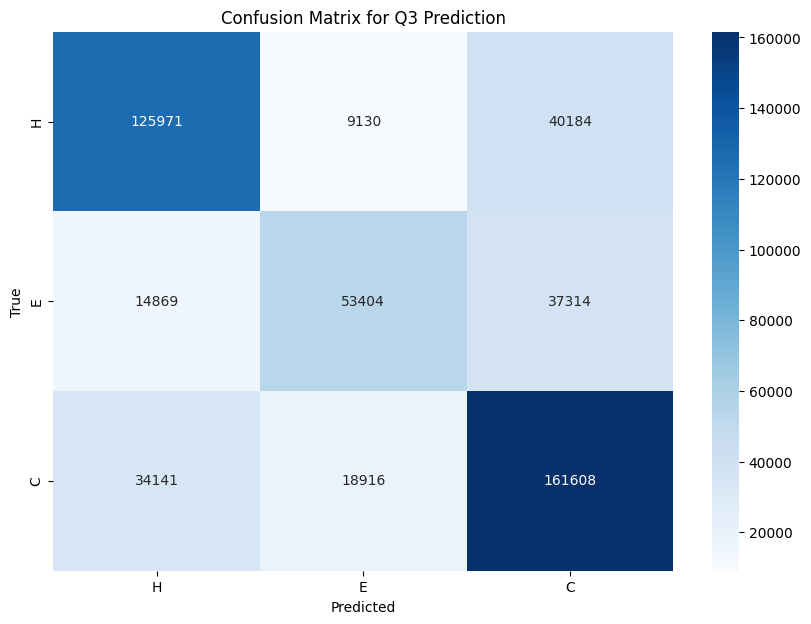

In [8]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['H', 'E', 'C'], yticklabels=['H', 'E', 'C'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Q3 Prediction')
plt.show()

# Save the model for future use
model.save('protein_secondary_structure_model.keras')